C:\Users\sotiv\AppData\Local\Temp\ipykernel_21604\3175232820.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(model_path)


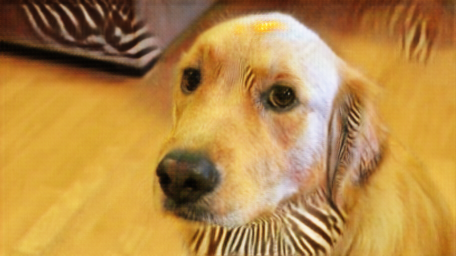

In [27]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)
        
# end of blah- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

netG = ResNetGenerator() #Chooses a network?

model_path = (r'C:\Users\sotiv\data\p1ch2\horse2zebra_0.4.0.pth') #Gives the model the horse/zebra data
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

netG.eval() #Note: This is only the network -- there are no weights so nothing is really happening!

# Image and data processing - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

preprocess = transforms.Compose([transforms.Resize(256), #Filters the data into network-friendly data 
                                 transforms.ToTensor()]) 

img = Image.open(r"C:\Users\sotiv\data\p1ch2\bobby.jpg")  #Get Image
img

img_t = preprocess(img) 
batch_t = torch.unsqueeze(img_t, 0) #Organizes data into the batch

# Data is sent through network- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

batch_out = netG(batch_t) #This is the result of the network working through the batch!

out_t = (batch_out.data.squeeze() + 1.0) / (2.0) #The result is made into a viewable image
out_img = transforms.ToPILImage()(out_t)
out_img.save(r'C:\Users\sotiv\data\p1ch2\horse.jpg')

# compare? - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
out_img



